# Выпускной проект

Нам доступно несколько дата-сетов, содержащих данные о клиентах телеком компании.\
Цель работы:
- Построить модель предсказывающую отток клиентов компании со значением метрики AUC-ROC не ниже 0,85.\

С точки зрения бизнеса, убытки возможны в двух случаях:
- Если мы не сможем предсказать отток клиентов и они уйдут (False Negative)
- Если мы неправильно это предскажем, что приведет к лишним затратам на повышение лоялности клиентов (False Positive)

А вот и сами дата-сеты:
- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.

Примерный план работ таков:
- Обзор предоставленных дата-сетов по отдельности
- Проверка на пропуски и дубликаты
- Сравнение кол-ва записей в дата-сетах
- Приведение столбцов к правилам хорошего тона (к змеиному стилю)
- Просмотр распределения значений (проверка на выбросы и аномалии)
- Приведение данных к корректному формату
- Предобработка дата-сетов
- Слияние дата-сетов в один
- Удаление ненужных для модели признаков
- Выбор 3-х моделей МО
- Разделение общего дата-сета на валидационную и тестовую выборки в пропорции 0,75 к 0,25 (валижация и тест соответственно)
- Настройка гиперпараметров
- Тестирование лучшей модели МО на тестовой выборке
- Формулировки итогового вывода + промежуточные выводы на различных этапах работы

P.S. Это, лишь, примерный план и при необходимости будем от него отступать

In [1]:
# Константы
state = 300723

# Пользовательские функции

In [2]:
# Функция для первичного анализа дата-сета
def analyze_df(df):
    # выводим размерность датафрейма
    display("Размерность датафрейма:")
    display(df.shape)
    display("")

    # выводим информацию о датафрейме
    display("Информация о датафрейме:")
    display(df.info())
    display("")

    # выводим статистическую информацию о датафрейме
    display("Статистическая информация о датафрейме:")
    display(df.describe())
    display("")

    # выводим первые 10 строк датафрейма
    display("Первые 10 строк датафрейма:")
    display(df.head(10))

    # выодим кол-во пропусков
    display("Кол-во пропусков")
    display(df.isna().sum())
    
    # выодим кол-во дубликатов
    display("Кол-во дубликатов")
    display(df.duplicated().sum())

In [3]:
# Приводим названия столбцов к нижнему регистру
def lower(df):
    df.columns = df.columns.str.lower()

In [4]:
# Добавление нового признака. Длительность контракта в днях
def get_dur(row):
    if row['end_date'] == 'No':
        return (pd.to_datetime('2020-02-01') - row['begin_date']).days
    elif pd.isnull(row['end_date']):
        return (pd.to_datetime('2020-02-01') - row['begin_date']).days
    else:
        return (row['end_date'] - row['begin_date']).days

# Импорты

In [5]:
pip install -U scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install skimpy

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install xgboost

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import phik
from phik.report import plot_correlation_matrix
from phik import resources, report
from skimpy import clean_columns
from catboost import CatBoostClassifier
import xgboost
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.inspection import permutation_importance

# Загрузка датафреймов

In [10]:
contract = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')
personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')
internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')
phone = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')

# Отображение основаных хар-к дата-сетов

In [11]:
analyze_df(contract)

'Размерность датафрейма:'

(7043, 8)

''

'Информация о датафрейме:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

''

'Статистическая информация о датафрейме:'

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


''

'Первые 10 строк датафрейма:'

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35


'Кол-во пропусков'

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

'Кол-во дубликатов'

0

In [12]:
analyze_df(personal)

'Размерность датафрейма:'

(7043, 5)

''

'Информация о датафрейме:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

''

'Статистическая информация о датафрейме:'

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


''

'Первые 10 строк датафрейма:'

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


'Кол-во пропусков'

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

'Кол-во дубликатов'

0

In [13]:
analyze_df(internet)

'Размерность датафрейма:'

(5517, 8)

''

'Информация о датафрейме:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

''

'Статистическая информация о датафрейме:'

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


''

'Первые 10 строк датафрейма:'

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


'Кол-во пропусков'

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

'Кол-во дубликатов'

0

In [14]:
analyze_df(phone)

'Размерность датафрейма:'

(6361, 2)

''

'Информация о датафрейме:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

''

'Статистическая информация о датафрейме:'

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


''

'Первые 10 строк датафрейма:'

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


'Кол-во пропусков'

customerID       0
MultipleLines    0
dtype: int64

'Кол-во дубликатов'

0

## Вывод о первом осмотре дата-сетов

Дата-сеты contract и personal не содержит пропусков и дубликатов.\
А вот с internet ситуация интересней. Можно с уверенностью сказать, что пропусков и тут нет, но самих строк много меньше (5517 против 7043 у contract и personal) это обуславливается тем, что не все клиенты компании пользуются данной услугой.\
А вот услугой телефонии пользуются чаще, чем интернетом тут уже 6361 строка и тоже нет пропусков.

# Предобработка данных

## Приводим названия столбцов к "правилам хорошего тона"

In [15]:
contract = clean_columns(contract)

# Проверяем
contract.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')

In [16]:
personal = clean_columns(personal)

# Проверяем
personal.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')

In [17]:
internet = clean_columns(internet)

# Проверяем
internet.columns

Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')

In [18]:
phone = clean_columns(phone)

# Проверяем
phone.columns

Index(['customer_id', 'multiple_lines'], dtype='object')

# Приводим данные к корректному формату

### Начнем с дата-сета "Contract"

In [19]:
# Приведем значения столбца "begin_date" к формату Datetime
contract['begin_date'] = pd.to_datetime(contract['begin_date'])

In [20]:
# Приведем значения столбца "end_date" к формату Datetime, оставив значение "No"
contract['end_date'] = contract['end_date'].apply(lambda x: pd.to_datetime(x) if x != 'No' else x)

In [21]:
# Приведем значения столбца "paperless_billing" к Булеву типу
contract['paperless_billing'] = contract['paperless_billing'].astype('bool')

In [22]:
# Приведем значения столбца "monthly_charges" к типу float
contract['monthly_charges'] = contract['monthly_charges'].astype('float')

In [23]:
# Приведем значения столбца "total_charges" к типу float
# contract['total_charges'] = contract['total_charges'].astype('float') - Этот код выдал ошибку

In [24]:
# Рассмотрим эти строки подробнее
spaces = contract[contract['total_charges'].str.contains(' ')]
spaces

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,No,Two year,True,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,True,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,True,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,True,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,True,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,True,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,True,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,True,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,True,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,True,Mailed check,73.35,


In [25]:
contract['total_charges'] = contract['total_charges'].replace(' ', np.nan) # Заменяем их на Nan
contract['total_charges'].isna().sum() # Подчитываем кол-во

11

In [26]:
# Удаляем эти 11 записей, выборку они уменьшат, лишь на доли процента. При этом они вряд-ли уйдут из компании, только что к ней присоеденившись
contract = contract.dropna().reset_index(drop=True)

Судя по всему, это не связано с техническими неполадками.\
Это новые абоненты, которые обслуживаются компанией меньше месяца (с 2го января), этим и обуславливаются пробелы в колонке с суммарными тратами.\

In [27]:
# А теперь снова попробуем привести значения столбца "total_charges" к типу float
contract['total_charges'] = contract['total_charges'].astype('float')

In [28]:
# Добавим признак длительности контракта в днях
contract['duration_days'] = contract.apply(get_dur, axis=1)

In [29]:
# Проверяем
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7032 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   end_date           7032 non-null   object        
 3   type               7032 non-null   object        
 4   paperless_billing  7032 non-null   bool          
 5   payment_method     7032 non-null   object        
 6   monthly_charges    7032 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   duration_days      7032 non-null   int64         
dtypes: bool(1), datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 446.5+ KB


In [30]:
contract.head(15)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,duration_days
0,7590-VHVEG,2020-01-01,No,Month-to-month,True,Electronic check,29.85,31.04,31
1,5575-GNVDE,2017-04-01,No,One year,True,Mailed check,56.95,2071.84,1036
2,3668-QPYBK,2019-10-01,No,Month-to-month,True,Mailed check,53.85,226.17,123
3,7795-CFOCW,2016-05-01,No,One year,True,Bank transfer (automatic),42.30,1960.60,1371
4,9237-HQITU,2019-09-01,No,Month-to-month,True,Electronic check,70.70,353.50,153
5,9305-CDSKC,2019-03-01,No,Month-to-month,True,Electronic check,99.65,1150.96,337
6,1452-KIOVK,2018-04-01,No,Month-to-month,True,Credit card (automatic),89.10,2058.21,671
7,6713-OKOMC,2019-04-01,No,Month-to-month,True,Mailed check,29.75,300.48,306
8,7892-POOKP,2017-07-01,No,Month-to-month,True,Electronic check,104.80,3573.68,945
9,6388-TABGU,2014-12-01,2017-05-01 00:00:00,One year,True,Bank transfer (automatic),56.15,1628.35,882


In [31]:
# Проверяем
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


### Далее дата-сет "internet"

In [32]:
# Проверяем
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


## Теперь посмотрим на распределение значений в дата-сетах
Это самый главный дата-сет и в нем наибольшее кол-во типов данных.\
Рассмотрим его более подробно

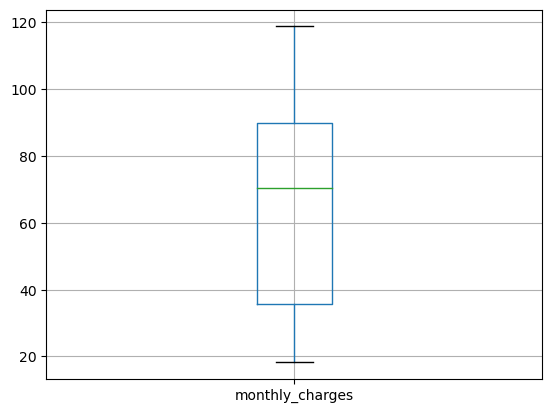

In [34]:
contract.boxplot(column='monthly_charges')
plt.show()

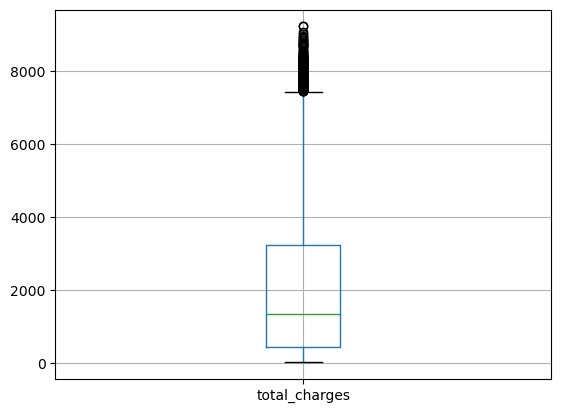

In [35]:
contract.boxplot(column='total_charges')
plt.show()

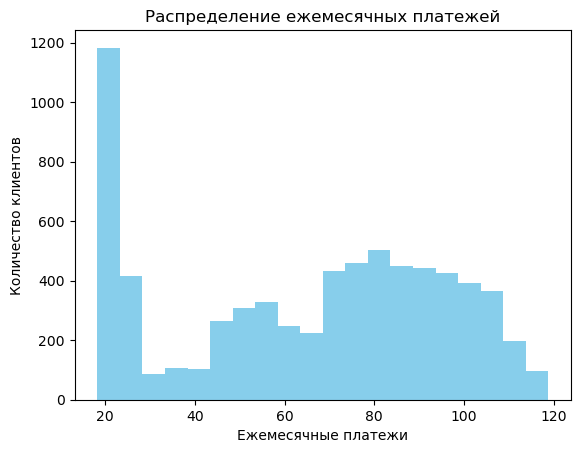

In [36]:
# Распределение ежемесячных платежей
plt.hist(contract['monthly_charges'], bins=20, color='skyblue')
plt.xlabel('Ежемесячные платежи')
plt.ylabel('Количество клиентов')
plt.title('Распределение ежемесячных платежей')
plt.show()


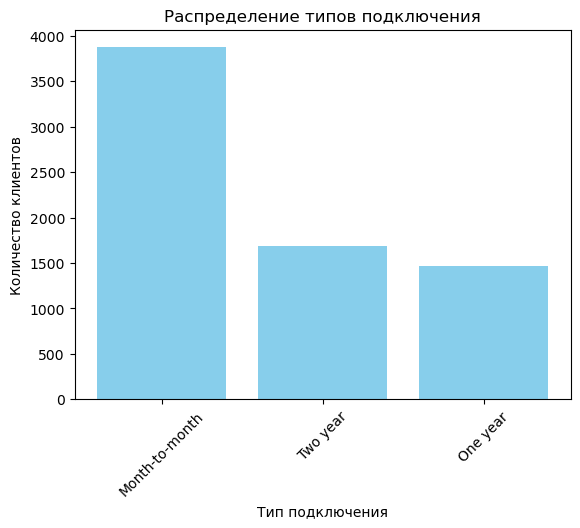

In [37]:
# Распределение типов подключения
type_counts = contract['type'].value_counts()
plt.bar(type_counts.index, type_counts.values, color='skyblue')
plt.xlabel('Тип подключения')
plt.ylabel('Количество клиентов')
plt.title('Распределение типов подключения')
plt.xticks(rotation=45)
plt.show()


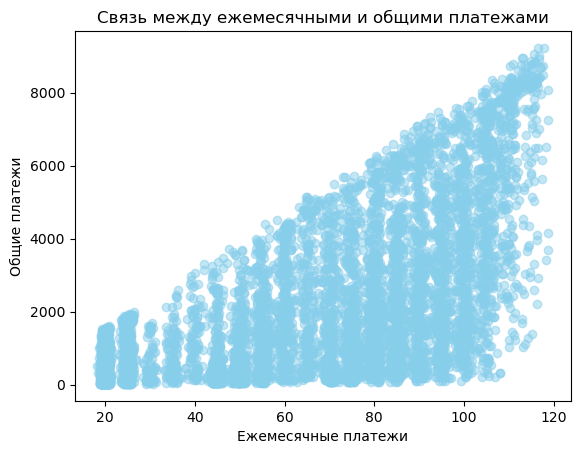

In [38]:
# Связь между ежемесячными и общими платежами
plt.scatter(contract['monthly_charges'], contract['total_charges'], color='skyblue', alpha=0.5)
plt.xlabel('Ежемесячные платежи')
plt.ylabel('Общие платежи')
plt.title('Связь между ежемесячными и общими платежами')
plt.show()


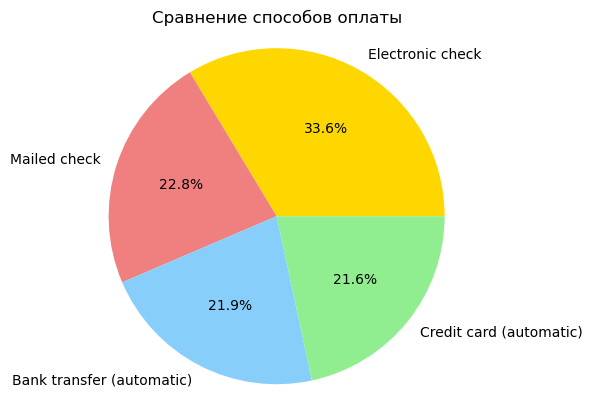

In [39]:
# Сравнение способов оплаты
payment_method_counts = contract['payment_method'].value_counts()
plt.pie(payment_method_counts, labels=payment_method_counts.index, autopct='%1.1f%%', colors=['gold', 'lightcoral', 'lightskyblue', 'lightgreen'])
plt.axis('equal')
plt.title('Сравнение способов оплаты')
plt.show()


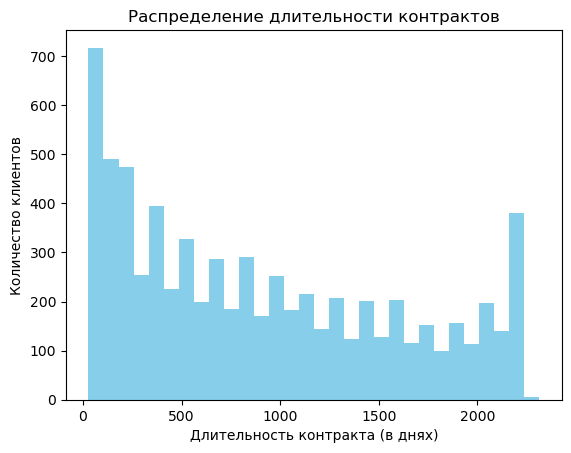

In [40]:
# Распределение длительности контрактов в днях
plt.hist(contract['duration_days'], bins=30, color='skyblue')
plt.xlabel('Длительность контракта (в днях)')
plt.ylabel('Количество клиентов')
plt.title('Распределение длительности контрактов')
plt.show()


## Personal
Так как тут только Булевы значиния, напишем цикл 

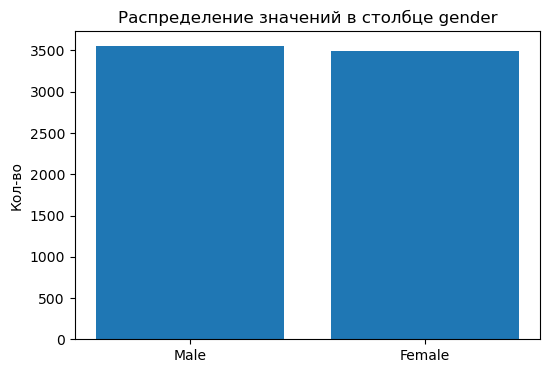

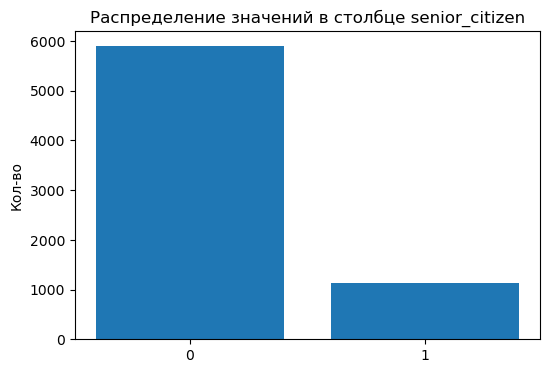

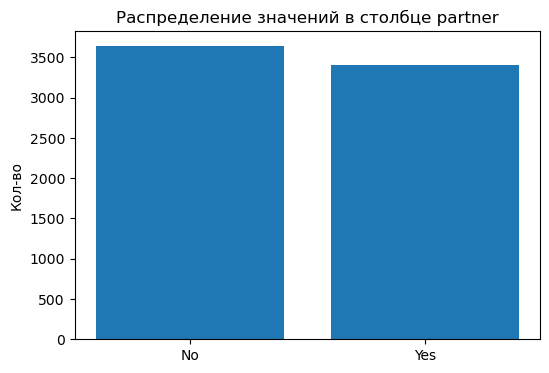

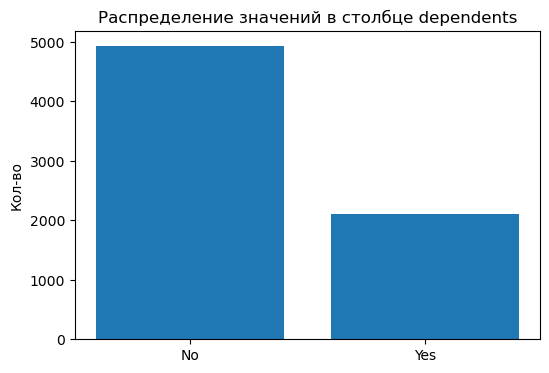

In [41]:
# Создание графиков распределения
for column in personal.columns[1:]:
    value_counts = personal[column].value_counts()
    plt.figure(figsize=(6, 4))
    plt.bar(value_counts.index.astype(str), value_counts.values)
    plt.title(f'Распределение значений в столбце {column}')
    plt.ylabel('Кол-во')
    plt.show()

## Internet
Рассмотрим его как и предыдущий датафрейм

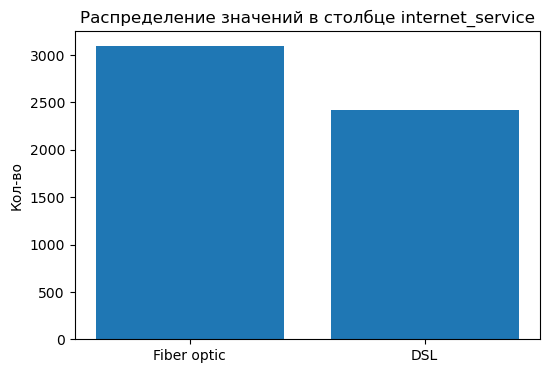

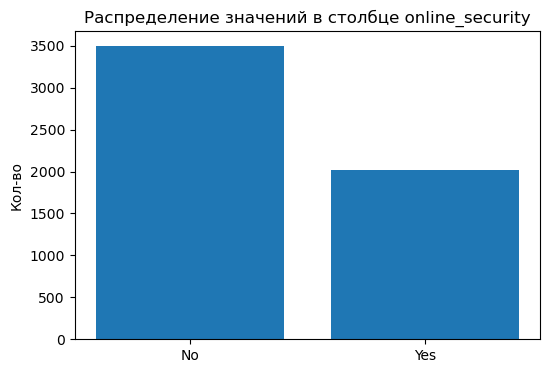

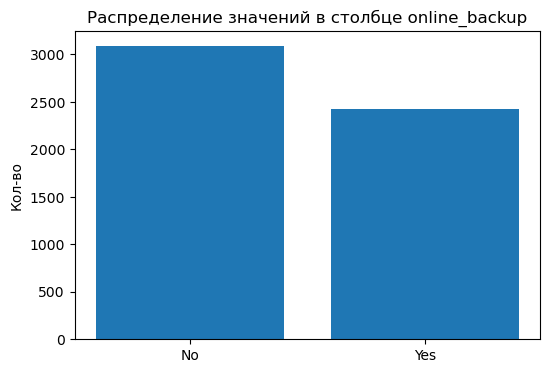

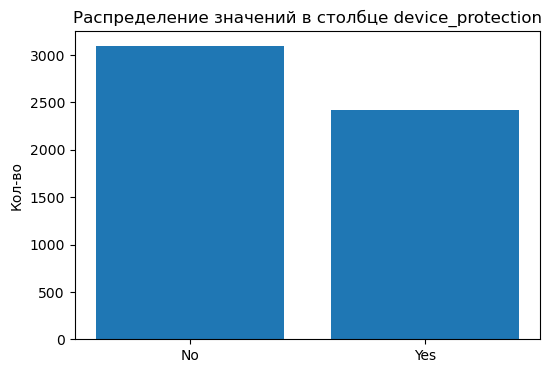

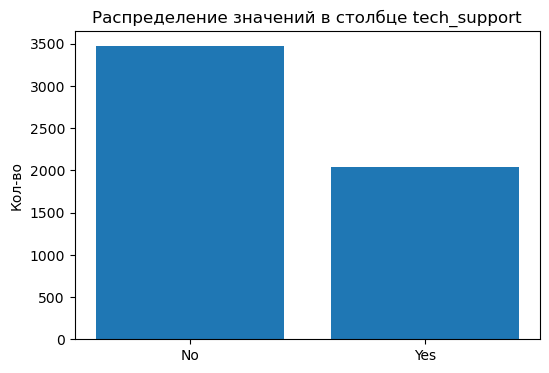

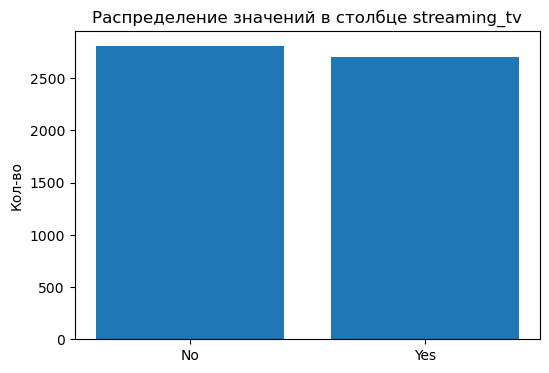

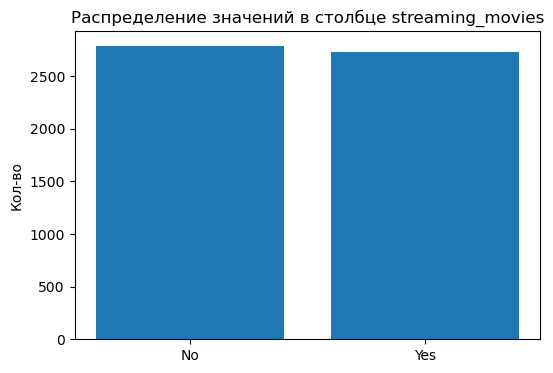

In [42]:
# Создание графиков распределения
for column in internet.columns[1:]:
    value_counts = internet[column].value_counts()
    plt.figure(figsize=(6, 4))
    plt.bar(value_counts.index.astype(str), value_counts.values)
    plt.title(f'Распределение значений в столбце {column}')
    plt.ylabel('Кол-во')
    plt.show()

## Phone

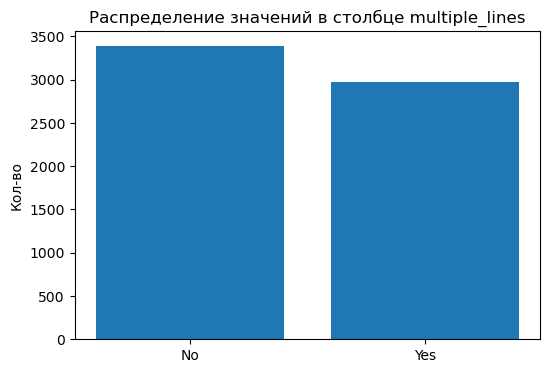

In [43]:
# Создание графиков распределения
for column in phone.columns[1:]:
    value_counts = phone[column].value_counts()
    plt.figure(figsize=(6, 4))
    plt.bar(value_counts.index.astype(str), value_counts.values)
    plt.title(f'Распределение значений в столбце {column}')
    plt.ylabel('Кол-во')
    plt.show()

## Вывод о предобработке данных
- Данные в столбцах датафреймов были приведенф в корректные форматы
- Большинство данных в столбцах могут принимать только два значения. Были заменены на Булев тип
- Были обнаружены 11 неявных пропусков (пробелов)
- Были выведены графики распределений значений. Больше всего внимание было уделено дата-сету "Contract" так как он является ключевым и в нем наибольшее разнообразие данных для исследовательского анализа (хоть это и не является целью нашего исследования)

Значимые итоги EDA:
- Касаемо распределения, ярко выражаются клиенты, потратившие суммарно более 8 000 на услуги компании
- Так же наблюдается большое кол-во небольших едемесячных платежей
- Большинство клиентов предпочитают ежемесячный тип оплаты
- Связь между ежемесячными и общими платежами, ожидаемо, прямая
- Большинство клиентов предпочитают электронные чеки, 33,6%. Остальные 66.4 процента практически равномерно распределены между: банковскими и почтовыми переводами и кредитными картами
- Распределение длительности контрактов имеет яркие всплески в околонудевых значениях и хначениях около 2000 дней. Видимо некоторым изначально не понравились услуги компании, а кому-то ,наоборот, очень понравились. Между этими крайностями длительность контрактов плавно уменьшается по мере возрастания кол-ва дней использования.
- Распределение клиентов по возрасту почти одинаковое, как и по наличию партнера.
А вот кол-во пенсионеров почти в 6 раз меньше, чем людей до пенсионного возраста (тысяча против почти 6 тыс)
- Иждевенцев имеют в 2,5 раза меньше, чем людей не имеющих иждивенцев (2 тыс. против 5 тыс.)

Это, лишь, самые значимые итоги EDA\
Далее переходим к объединению таблиц

# Объеденияем дата-сеты

Для объеденения датафреймов будем использовать метод merge(), так как он позволит сопоставить значения по ключу (ID)

In [44]:
# Объединяем датафреймы по ключевому столбцу customer_id
data = contract.merge(personal,how='left', on='customer_id').merge(internet,how='left', on='customer_id').merge(phone,how='left', on='customer_id')

## Проверим корректность объединения и изучим итоговый датафрейм

In [45]:
analyze_df(data)

'Размерность датафрейма:'

(7032, 21)

''

'Информация о датафрейме:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7032 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   end_date           7032 non-null   object        
 3   type               7032 non-null   object        
 4   paperless_billing  7032 non-null   bool          
 5   payment_method     7032 non-null   object        
 6   monthly_charges    7032 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   duration_days      7032 non-null   int64         
 9   gender             7032 non-null   object        
 10  senior_citizen     7032 non-null   int64         
 11  partner            7032 non-null   object        
 12  dependents         7032 non-null   object        
 13  internet_service   5512 non-null   object        
 14  online_s

None

''

'Статистическая информация о датафрейме:'

,begin_date,monthly_charges,total_charges,duration_days,senior_citizen
count,7032,7032.000000,7032.000000,7032.000000,7032.000000
mean,2017-04-28 23:14:44.641638400,64.798208,2118.621822,899.961320,0.162400
min,2013-10-01 00:00:00,18.250000,19.050000,28.000000,0.000000
25%,2015-06-01 00:00:00,35.587500,439.745000,276.000000,0.000000
50%,2017-09-01 00:00:00,70.350000,1345.275000,761.000000,0.000000
75%,2019-04-01 00:00:00,89.862500,3239.317500,1461.000000,0.000000
max,2020-01-01 00:00:00,118.750000,9221.380000,2314.000000,1.000000
std,NaN,30.085974,2112.736199,682.738777,0.368844


''

'Первые 10 строк датафрейма:'

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,duration_days,gender,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,True,Electronic check,29.85,31.04,31,Female,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,True,Mailed check,56.95,2071.84,1036,Male,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,True,Mailed check,53.85,226.17,123,Male,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,True,Bank transfer (automatic),42.30,1960.60,1371,Male,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,True,Electronic check,70.70,353.50,153,Female,...,No,No,Fiber optic,No,No,No,No,No,No,No
5,9305-CDSKC,2019-03-01,No,Month-to-month,True,Electronic check,99.65,1150.96,337,Female,...,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
6,1452-KIOVK,2018-04-01,No,Month-to-month,True,Credit card (automatic),89.10,2058.21,671,Male,...,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes
7,6713-OKOMC,2019-04-01,No,Month-to-month,True,Mailed check,29.75,300.48,306,Female,...,No,No,DSL,Yes,No,No,No,No,No,NaN
8,7892-POOKP,2017-07-01,No,Month-to-month,True,Electronic check,104.80,3573.68,945,Female,...,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes
9,6388-TABGU,2014-12-01,2017-05-01 00:00:00,One year,True,Bank transfer (automatic),56.15,1628.35,882,Male,...,No,Yes,DSL,Yes,Yes,No,No,No,No,No


'Кол-во пропусков'

customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
duration_days           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1520
online_security      1520
online_backup        1520
device_protection    1520
tech_support         1520
streaming_tv         1520
streaming_movies     1520
multiple_lines        680
dtype: int64

'Кол-во дубликатов'

0

## Заполним пропуски на заглушки

In [46]:
# "phone not used" применим только для столбцв дата-сета Phone
data['multiple_lines'] = data['multiple_lines'].fillna("phone not used")

# Проверяем
data['multiple_lines'].isna().sum()

0

In [47]:
# Остальные столбцы их датафрейма Internet, используем для заполнения пропуска в них "inet not used"
data = data.fillna("inet not used")

In [48]:
# Проверяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7032 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   end_date           7032 non-null   object        
 3   type               7032 non-null   object        
 4   paperless_billing  7032 non-null   bool          
 5   payment_method     7032 non-null   object        
 6   monthly_charges    7032 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   duration_days      7032 non-null   int64         
 9   gender             7032 non-null   object        
 10  senior_citizen     7032 non-null   int64         
 11  partner            7032 non-null   object        
 12  dependents         7032 non-null   object        
 13  internet_service   7032 non-null   object        
 14  online_s

## Вывод об объединении
В итоговом дата-сете 21 столбец, 7032 строк\
Появление пропусков ожидаемо, из-за разного кол-ва строк в исходных датафреймах\
Пропуски заполнены "заглушками" "inet not used" "phone not used" так-как пропуски образовались только в столбцах исходных "internet" и "phone"\
Столбцы, в которых применялись заглушки изменили формат с Булева на Object, но это нормально и с этим ничего не поделать (не имеет смысла пропуски заполнять как False)

In [49]:
# Установим столбце customer_id в качестве индекса
data.set_index('customer_id', inplace=True, drop=True)

# Проверяем
data.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,duration_days,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customer_id,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,True,Electronic check,29.85,31.04,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,phone not used
5575-GNVDE,2017-04-01,No,One year,True,Mailed check,56.95,2071.84,1036,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,No,Month-to-month,True,Mailed check,53.85,226.17,123,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,No,One year,True,Bank transfer (automatic),42.30,1960.60,1371,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,phone not used
9237-HQITU,2019-09-01,No,Month-to-month,True,Electronic check,70.70,353.50,153,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [50]:
# Создание ключевого признака exited. Предполагается, что есть в столбце end_date значение "No", то клиент не ушел, а если там конкретная дата, то ушел
data['exited'] = data['end_date'].apply(lambda x: 0 if x == 'No' else 1)

# Проверяем
data.head(10)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,duration_days,gender,senior_citizen,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,exited
customer_id,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,True,Electronic check,29.85,31.04,31,Female,0,...,No,DSL,No,Yes,No,No,No,No,phone not used,0
5575-GNVDE,2017-04-01,No,One year,True,Mailed check,56.95,2071.84,1036,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,No,0
3668-QPYBK,2019-10-01,No,Month-to-month,True,Mailed check,53.85,226.17,123,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,No,0
7795-CFOCW,2016-05-01,No,One year,True,Bank transfer (automatic),42.30,1960.60,1371,Male,0,...,No,DSL,Yes,No,Yes,Yes,No,No,phone not used,0
9237-HQITU,2019-09-01,No,Month-to-month,True,Electronic check,70.70,353.50,153,Female,0,...,No,Fiber optic,No,No,No,No,No,No,No,0
9305-CDSKC,2019-03-01,No,Month-to-month,True,Electronic check,99.65,1150.96,337,Female,0,...,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,0
1452-KIOVK,2018-04-01,No,Month-to-month,True,Credit card (automatic),89.10,2058.21,671,Male,0,...,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes,0
6713-OKOMC,2019-04-01,No,Month-to-month,True,Mailed check,29.75,300.48,306,Female,0,...,No,DSL,Yes,No,No,No,No,No,phone not used,0
7892-POOKP,2017-07-01,No,Month-to-month,True,Electronic check,104.80,3573.68,945,Female,0,...,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes,0


In [51]:
# Исследуем баланс классов
data['exited'].value_counts()

exited
0    5931
1    1101
Name: count, dtype: int64

Касаемо баланса классов. Он составляет 1 к 6, упущенных клиентов к оставшимся (1101 к 5931 клиентам)\
Так как мы используем метрику, устойчивую к дисбалансу классов, бороться с ним во всем датафрейме мы не будем.\
Используем модели устойчивые к дисбалансу, а где это не получится, будем бороться с ним настроив сами модели.

In [52]:
# Будем использовать Фик корреляцию, так как у нас имеются как численные признаки, так и категориальные
interval_cols = ['monthly_charges', 'total_charges', 'duration_days']

data.phik_matrix(interval_cols=interval_cols)

c:\Users\feras\anaconda3\envs\ds_practicum_env\lib\site-packages\phik\data_quality.py:82: UserWarning: Not enough unique value for variable paperless_billing for analysis 1. Dropping this column
  warnings.warn(


,begin_date,end_date,type,payment_method,monthly_charges,total_charges,duration_days,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,exited
begin_date,1.000000,0.549761,0.765275,0.467586,0.421848,0.773731,0.978241,0.018540,0.049516,0.485513,0.201169,0.185601,0.459336,0.495096,0.501372,0.454019,0.418173,0.429770,0.468346,0.461977
end_date,0.549761,1.000000,0.286678,0.168837,0.172986,0.215829,0.399183,0.018351,0.090149,0.178225,0.056795,0.116149,0.166274,0.236566,0.226005,0.150222,0.186040,0.198643,0.249694,1.000000
type,0.765275,0.286678,1.000000,0.277528,0.388557,0.470700,0.635623,0.000000,0.085800,0.179294,0.146126,0.503776,0.636227,0.580887,0.630968,0.671126,0.548723,0.553780,0.244802,0.094622
payment_method,0.467586,0.168837,0.277528,1.000000,0.398849,0.334563,0.348275,0.000000,0.291989,0.244661,0.222859,0.323013,0.314888,0.292646,0.297187,0.316805,0.283902,0.284844,0.174953,0.214300
monthly_charges,0.421848,0.172986,0.388557,0.398849,1.000000,0.711015,0.387649,0.005522,0.304546,0.204575,0.182283,0.919005,0.812548,0.818861,0.827363,0.816645,0.864821,0.863544,0.710293,0.225823
total_charges,0.773731,0.215829,0.470700,0.334563,0.711015,1.000000,0.847572,0.000000,0.136856,0.383135,0.085809,0.489363,0.516500,0.550605,0.558748,0.527978,0.555663,0.554074,0.467826,0.303758
duration_days,0.978241,0.399183,0.635623,0.348275,0.387649,0.847572,1.000000,0.000000,0.065128,0.450246,0.197317,0.058903,0.345964,0.367533,0.376886,0.352799,0.308923,0.307383,0.347224,0.374101
gender,0.018540,0.018351,0.000000,0.000000,0.005522,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008800
senior_citizen,0.049516,0.090149,0.085800,0.291989,0.304546,0.136856,0.065128,0.000000,1.000000,0.018075,0.323629,0.160452,0.127108,0.109855,0.110029,0.135073,0.111610,0.113611,0.087978,0.085708
partner,0.485513,0.178225,0.179294,0.244661,0.204575,0.383135,0.450246,0.000000,0.018075,1.000000,0.651635,0.000000,0.091140,0.091990,0.099685,0.076244,0.081850,0.077710,0.086495,0.227597


c:\Users\feras\anaconda3\envs\ds_practicum_env\lib\site-packages\phik\data_quality.py:82: UserWarning: Not enough unique value for variable paperless_billing for analysis 1. Dropping this column
  warnings.warn(


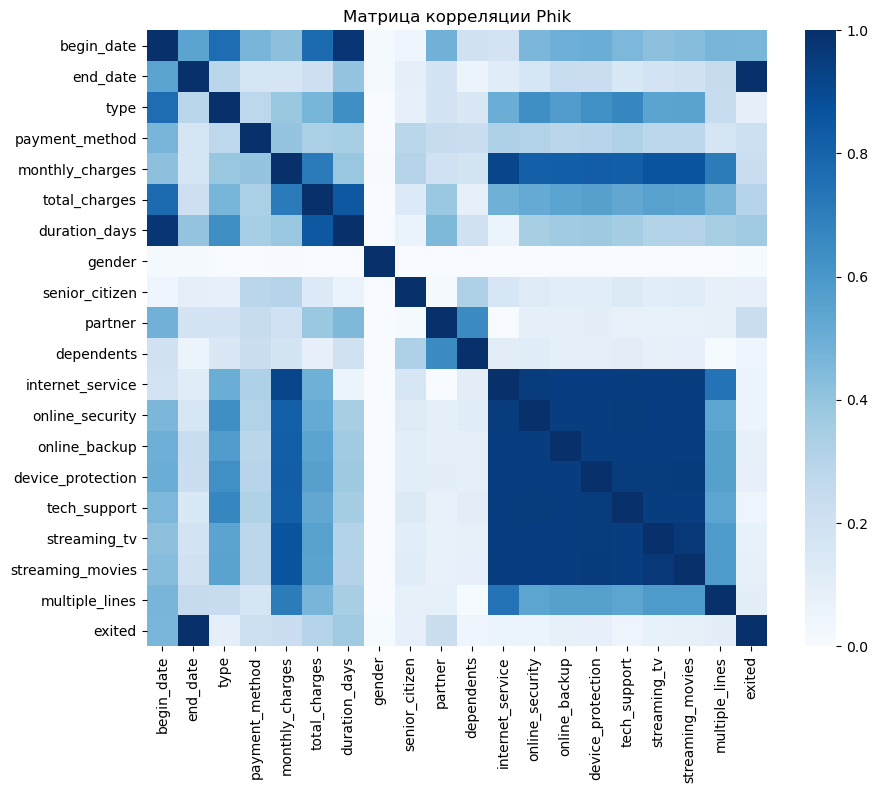

In [53]:
# Визуализируем выприведенную матрицу и добавим ее цвета
phik_matrix = data.phik_matrix(interval_cols=interval_cols)

plt.figure(figsize=(10, 8))
sns.heatmap(phik_matrix, cmap='Blues')
plt.title("Матрица корреляции Phik")
plt.show()

## Вывод о EDA и предобработке данных
- Было выполнено слияние датафреймов для удобства и подачи максимального кол-ва данных моделям МО
- "customer_id" был установлен в качестве индекса. Так он не будет потерян, но и не будет использоваться в качестве признака
- Была построена матрица корреляции Phik, ввиду наличия как категориальных, так и численных признаков

По матрице корреляции наблюдается:
- Высокая корреляция даты начала обслуживания и длительностью контракта
- Высокая корреляция пользования услугами "интернет" и ужемесячным платежом. Видимо, интернет дороже услуг телефонии
- Многие клиенты используют услуги из дата-сета internet пакетом. Высокая взаимная корреляцие этих признаков между собой
- Высокая корреляция наличия партнера и иждивенцев. Лигично, семьи заводят детей
- Отдельно отмечу низкую корреляция прекращение договора с компанией и длительностью договора. Просто так клиенты не уходят. Рекомендуется повысить качество услуг

Касаемо баланса классов. Он составляет 1 к 6, упущенных клиентов к оставшимся (1101 к 5931 клиентам)\
Так как мы используем метрику, устойчивую к дисбалансу классов, бороться с ним во всем датафрейме мы не будем.\
Используем модели устойчивые к дисбалансу, а где это не получится, будем бороться с ним настроив сами модели.

In [54]:
data.pivot_table(index=data['exited'], aggfunc='count')


,begin_date,dependents,device_protection,duration_days,end_date,gender,internet_service,monthly_charges,multiple_lines,online_backup,online_security,paperless_billing,partner,payment_method,senior_citizen,streaming_movies,streaming_tv,tech_support,total_charges,type
exited,,,,,,,,,,,,,,,,,,,,
0,5931,5931,5931,5931,5931,5931,5931,5931,5931,5931,5931,5931,5931,5931,5931,5931,5931,5931,5931,5931
1,1101,1101,1101,1101,1101,1101,1101,1101,1101,1101,1101,1101,1101,1101,1101,1101,1101,1101,1101,1101


# Подготовка к обучению моделей МО

In [55]:
# Удалим столбцы 'begin_date' и 'end_date'. Они коррелируют с признаком длительности контракта, а второй фактически дублирует целевой признак
data = data.drop(['begin_date', 'end_date'], axis=1)

# Проверяем
data.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,duration_days,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,exited
customer_id,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,True,Electronic check,29.85,31.04,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,phone not used,0
5575-GNVDE,One year,True,Mailed check,56.95,2071.84,1036,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0
3668-QPYBK,Month-to-month,True,Mailed check,53.85,226.17,123,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,0
7795-CFOCW,One year,True,Bank transfer (automatic),42.30,1960.60,1371,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,phone not used,0
9237-HQITU,Month-to-month,True,Electronic check,70.70,353.50,153,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,0


## Разделим дата-сет на обучающую и тестовую выборки
Согласно ТЗ, соотношение будет 0,75 обучающей к 0,25 тестовой выборкам

In [56]:
# Объявим переменные для признаков и целевого признака
features = data.drop("exited", axis=1)
target = data["exited"]

# Проверяем размерности
display(features.shape, target.shape)

(7032, 18)

(7032,)

In [57]:
# Разделим датафрейм на валидационную и тестовую выборки в пропорции 0,75 к 0,25
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                        target,
                                                                        test_size=0.25,
                                                                        random_state= state)

# Проверяем
display(features_train.shape, features_test.shape, target_train.shape, target_test.shape)

(5274, 18)

(1758, 18)

(5274,)

(1758,)

## Кодирование категориальных признаков

In [58]:
# Определите индексы числовых и категориальных признаков
numerical_features = ['monthly_charges', 'total_charges', 'duration_days']
categorical_features = features.drop(numerical_features, axis=1).columns.tolist()

# Создаем ColumnTransformer для применения преобразований к признакам
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Масштабирование числовых признаков
        ('cat', OneHotEncoder(), categorical_features)   # Кодирование категориальных признаков
    ])

# Создаем pipeline, который применяет предобработку
pipeline_prep = Pipeline(steps=[('preprocessor', preprocessor)])

# Применяем предобработку к тренировочным данным
features_train_preprocessed = pipeline_prep.fit_transform(features_train)

# Теперь к тестовым
features_test_preprocessed = pipeline_prep.transform(features_test)


# Обучение моделей

In [59]:
def training(model, params):
    pipeline = Pipeline(
        [('model', model)]
        )
    grid = GridSearchCV(pipeline, cv = 5, n_jobs = -1, param_grid = params ,scoring = 'roc_auc', verbose = False)
    grid.fit(features_train_preprocessed, target_train)
    feature_importances = grid.best_estimator_.named_steps["model"].feature_importances_
    print('Лучший результат:', grid.best_score_)
    print('Лучшие параметры:', grid.best_params_)
    print('Важность признаков', feature_importances)

    # Визуализация важности признаков
    feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
    all_feature_names = numerical_features + list(feature_names)
    sorted_idx = feature_importances.argsort()[::-1]
    plt.bar(range(len(feature_importances)), feature_importances[sorted_idx])
    plt.xticks(range(len(feature_importances)), [all_feature_names[i] for i in sorted_idx], rotation=90)
    plt.xlabel("Признак")
    plt.ylabel("Важность признака")
    plt.title("Важность признаков")
    plt.show()
    
    return grid, grid.best_params_, feature_importances

## Random forest

Лучший результат: 0.8206221796069209
Лучшие параметры: {'model__max_depth': 8, 'model__min_samples_split': 8}
Важность признаков [0.0910256  0.1579311  0.24746291 0.04865817 0.01343423 0.03143637
 0.         0.00844899 0.01178383 0.00833717 0.02249007 0.0066262
 0.0074683  0.0068963  0.00631965 0.03569788 0.03013239 0.00922089
 0.00846494 0.00596442 0.00971112 0.00207677 0.00674431 0.00745457
 0.00230994 0.01096616 0.0219695  0.00235332 0.01291509 0.02618748
 0.00151668 0.00675996 0.00745215 0.0014179  0.00807015 0.00838931
 0.00182109 0.00971708 0.01750172 0.00116153 0.0388281  0.03257082
 0.00430581]


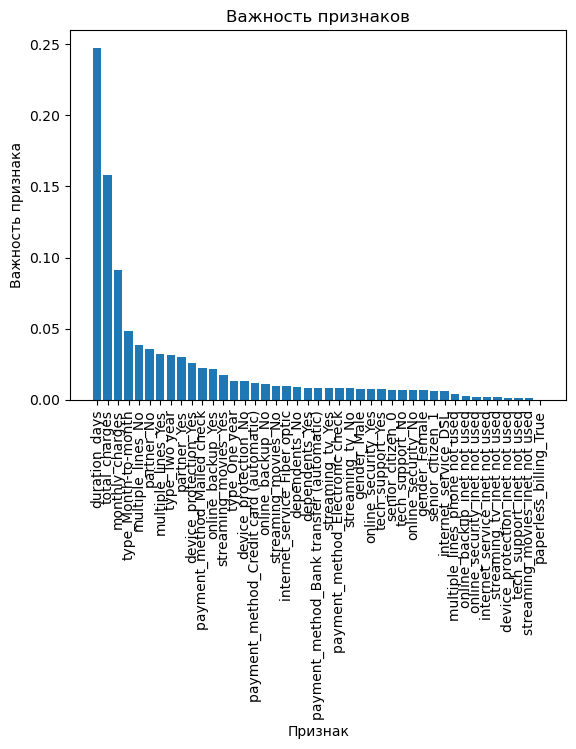

In [60]:
rf_balanced = training(RandomForestClassifier(random_state=state, class_weight='balanced'),
                       {'model__max_depth': [2, 4, 8],
                        'model__min_samples_split': [2, 4, 8]})

Лучший результат: 0.8226613932668689
Лучшие параметры: {'model__max_depth': 8, 'model__min_samples_split': 4}
Важность признаков [0.12544778 0.1653057  0.19817386 0.04741286 0.0169264  0.036395
 0.         0.01228429 0.01404431 0.00960199 0.01637142 0.00788614
 0.00852621 0.0091155  0.01132033 0.03433736 0.02462465 0.0108972
 0.00978073 0.00730527 0.01225571 0.00187732 0.00918086 0.00759292
 0.00220716 0.01296428 0.02137124 0.00108692 0.01152488 0.02515594
 0.00076981 0.00674878 0.00937309 0.00173695 0.00762108 0.01087395
 0.00156552 0.009164   0.01558282 0.00117684 0.02936416 0.03081813
 0.00423061]


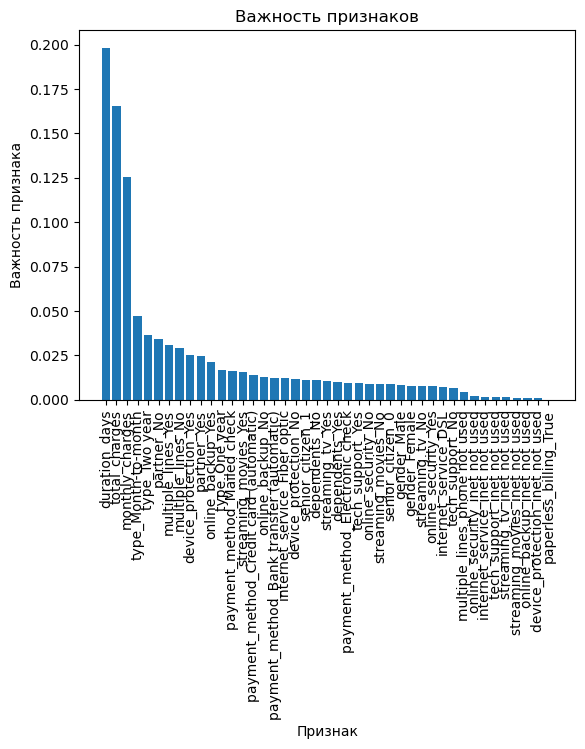

In [61]:
rf_none = training(RandomForestClassifier(random_state=state, class_weight=None),
                   {'model__max_depth': [2, 4, 8],
                    'model__min_samples_split': [2, 4, 8]})

## CatBoost classifier

Лучший результат: 0.8383293613034434
Лучшие параметры: {'model__depth': 4, 'model__iterations': 200, 'model__learning_rate': 0.03}
Важность признаков [5.02778245e+00 7.37460189e+00 4.15722130e+01 1.02355446e+01
 1.18948242e-01 5.48814839e+00 0.00000000e+00 4.36491066e-01
 9.02761242e-01 4.70708630e-01 4.00017947e+00 4.39146398e-02
 7.07211037e-02 2.84678569e-01 3.19971903e-01 2.74866395e+00
 3.07164430e+00 2.40512505e-01 5.01900398e-01 3.31189644e-01
 8.95281859e-01 0.00000000e+00 1.49250111e-01 2.05082032e-01
 0.00000000e+00 3.33942079e-01 2.32412175e+00 2.31379320e-01
 8.36392050e-01 2.02710696e+00 0.00000000e+00 2.23494391e-01
 1.77528964e-01 0.00000000e+00 1.83463057e-02 1.86078515e-01
 7.68551019e-02 2.76276004e-01 8.30498589e-01 6.88499656e-01
 3.80194694e+00 2.64132873e+00 8.36014692e-01]


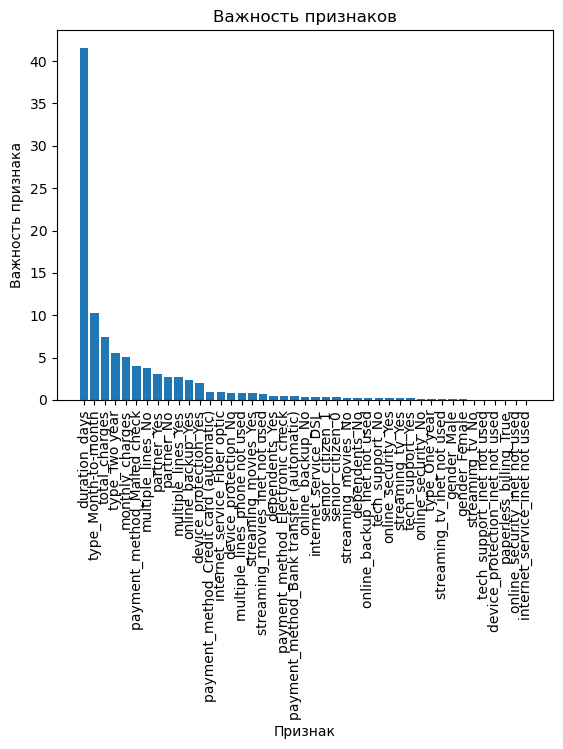

In [62]:
cat = training(CatBoostClassifier(random_state=state, logging_level='Silent'),
               {'model__depth': [2, 4, 8],
                'model__learning_rate' : [0.01,0.03],
                'model__iterations' : [50, 200]})

## XGBoost Classifier

Лучший результат: 0.8908158772003372
Лучшие параметры: {'model__max_depth': 4, 'model__min_child_weight': 1}
Важность признаков [0.02600308 0.02414989 0.04401852 0.11712497 0.01219788 0.07743476
 0.         0.01454362 0.01633784 0.01425405 0.07997762 0.01167343
 0.         0.02643357 0.         0.06584282 0.         0.02270325
 0.         0.00771473 0.         0.         0.01697742 0.00819397
 0.         0.0163952  0.05727509 0.         0.03077711 0.03420281
 0.         0.02429314 0.01214963 0.         0.01721193 0.00792708
 0.         0.00536452 0.0097157  0.         0.11690657 0.05396728
 0.0282325 ]


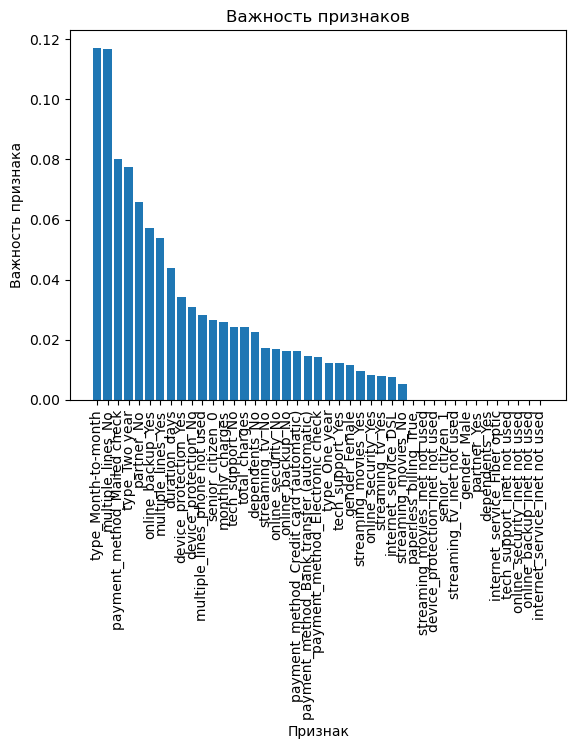

In [63]:
xgb = training(XGBClassifier(random_state=state, scale_pos_weight=1, eval_metric='logloss'), 
                        {'model__max_depth': [2, 4, 8],
                         'model__min_child_weight': [1, 2, 3]})

# Вывод об обучении моделей
Искомому значению метрики ROC_AUC соответствуют лишь 2 модели, обе - градиентный бустинг. XGBoost Classifier и LighthGBM Classifier\
Пальму первенства смело присваиваем модели XGBoost Classifier за недостижимое для других моделей значение метрики качества 0,89 при адекватном времени обучения в 8 сек.\
Далее проверка этой модели на тестовой выборке\
Важнейшими метриками модель посчитала:
- Тип оплаты контракта
- Использование технолонии "несколько линий"
- Тип оплаты
- Длительность контракта

# Тестирование

In [64]:
# Извлекаем модель из кортежа
xgb_model = xgb[0]
xbg_params = xgb[1]

result = roc_auc_score(target_test, xgb_model.predict_proba(features_test_preprocessed)[:, 1])

# Вероятности принадлежности классу 1
probabilities = xgb_model.predict_proba(features_test_preprocessed)[:, 1]

# Вычисление ROC-AUC
roc_auc = roc_auc_score(target_test, probabilities)

print("Результат XGBoost на тестовой выборке", result)

Результат XGBoost на тестовой выборке 0.9087282747672051


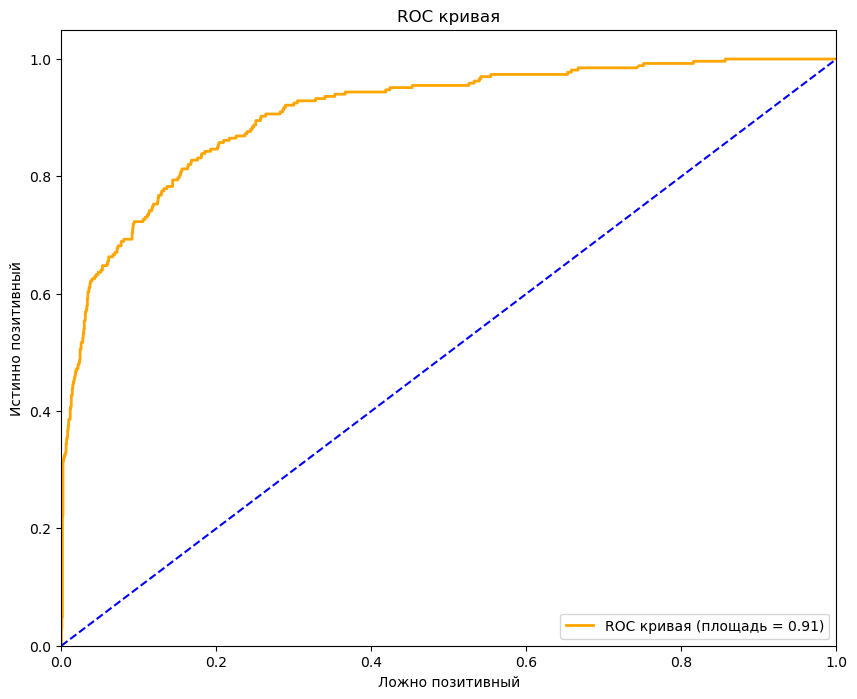

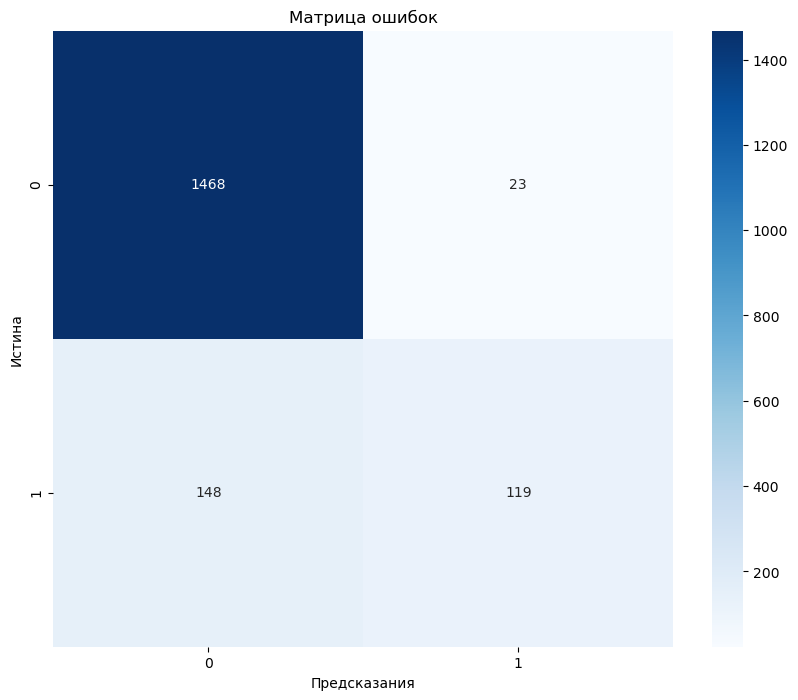

In [65]:
# Вывод ROC-кривой
fpr, tpr, _ = roc_curve(target_test, probabilities)
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='orange', lw=2, label='ROC кривая (площадь = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ложно позитивный')
plt.ylabel('Истинно позитивный')
plt.title('ROC кривая')
plt.legend(loc="lower right")
plt.show()

# Вычислкние матрицы ошибок
y_pred = xgb_model.best_estimator_.predict(features_test_preprocessed)
cm = confusion_matrix(target_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Предсказания')
plt.ylabel('Истина')
plt.title('Матрица ошибок')
plt.show()

# Вывод
Итак, в данном исследовании был проведен исследовательский анализ, предобработка, кодирование данных и построение нескольких моделей МО для предсказания оттока клиентов телеком провайдера\
Искомое значение метрики качества ROC-AUC было достигнуто моделью градиентного бустинга XGBoost\
На тренировочной выборке модель показала качество 89%, а на тестовой все 90%\
На этом исследование можно завершать, считая его успешным\
Судя по матрице ошибок, чаще всего модель ошибается в сторону ложно-негативных предсказаний (False negative)

# Отчет о выполненной работе

В ходе данной работы было выполнено
- Исследовательский анализ данных
- Изучены все 3 исходных датафрейма
- Проанализированы распределения всех признаков в исходных дата-сетах
- Названия столбцов приведени к змеиному стилю
- Данные исходных датафреймов приведени к корректному формату
- Дата-сеты изучены на предмет пропусков и дубликатов
- Исходные датафреймы объеденены в один для передачи в модели всех имеющихся признаков
- Исследована корреляция всех признаков методом Phik
- Пропуски в получившимся датасрейме заменены на подходящие заглушки
- Выделен целевой признак
- Удалены столбцы, фактически дублирующие целевой признак, во избежании утечки данных
- Исследован баланс классов
- Дата-сет разделен на тренировочную и тестовую выборки
- Категориальные признаки закодированы
- Построен Pipeline для обучения моделей и визуализации важнейших признаков
- Модели обучены и оценены. Лучшей оказалась модель XGBoost
- Тестирование лучшей модели и визуализация результата (ROC-AUC и важнейшие признаки)

Итак, все пункты плана работы были выполнены\
Лучшей моделью оказалась XGBoost classifier. Метрика ROC-AUC достигла значений 90% на тестовых данных\
Гиперпараметры модели:  {'model__max_depth': 4, 'model__min_child_weight': 1}\

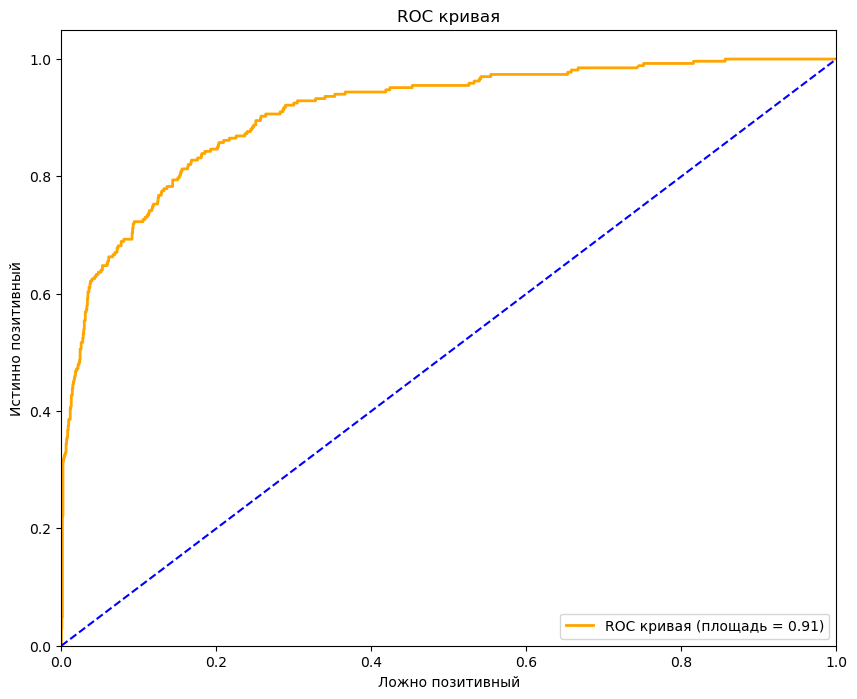

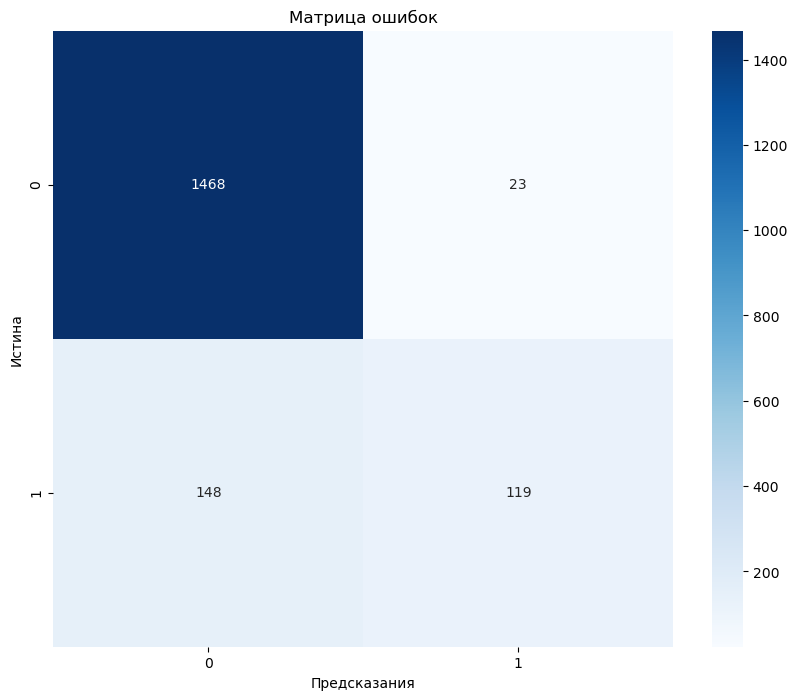

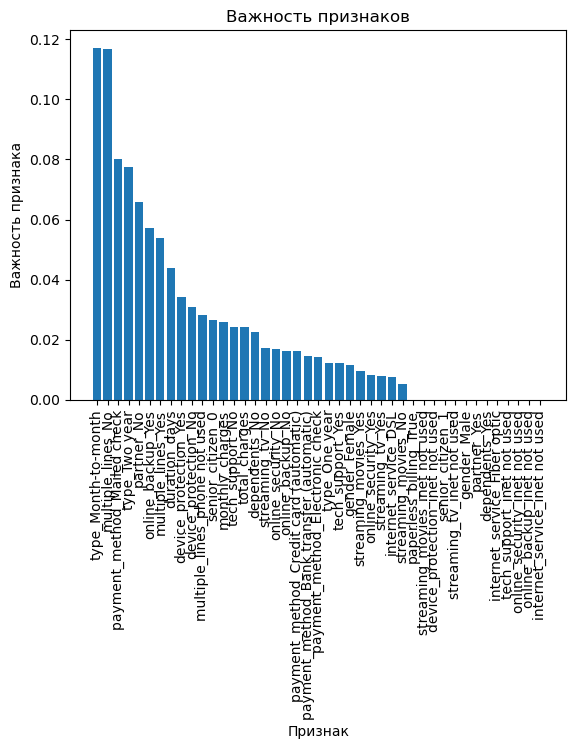



